<h1><center><b>Εκπαίδευση Μοντέλου Μηχανικής Μάθησης</b></center></h1>

Στη παρούσα φάση έχουμε δημιουργήσει τα δεδομένα με τα οποία θα εκπαιδεύσουμε και θα αξιολογήσουμε το μοντέλο μηχανικής μάθησης. Ήρθε λοιπόν η ώρα να δημιουργήσουμε αυτό το μοντέλο και να το εκπαιδεύσουμε με τα δεδομένα μας.

Για τη __δημιουργία__ και __εκπαίδευση__ του μοντέλου, θα χρησιμοποιήσουμε το εργαλείο [PyTorch][pytorch_link] της Python, μία __βιβλιοθήκη__ ειδικά σχεδιασμένη για __τεχνητή νοημοσήνη__, η οποία περιέχει χρήσιμα _εργαλεία_ και απαραίτητους _αλγορίθμους_ __μηχανικής μάθησης__.

<center><img src="https://assets-global.website-files.com/5f6bc60e665f54db361e52a9/637f8955a0d9698c6d768464_pytorch-logo.jpeg" width=500></center>

[pytorch_link]: https://pytorch.org/

## Αναπαραγωγιμότητα (Reproducibility)

Αρχικά θα φροντίσουμε να πληρείται το φαινόμενο της [__αναπαραγωγιμότητας__][reproducibility_link] (reproducibility), το οποίο συνεπάγεται στο ότι κάθε φορά θα έχουμε τις __ίδιες__ ακριβώς __συνθήκες__ κατά τη διαδικασία __εκπαίδευσης__ του μοντέλου. Αυτό σημαίνει πως η __αρχικοποίηση__ των __βαρών__ και η __σειρά__ των δεδομένων στα _batches_ θα να είναι κάθε φορά ίδια, ώστε η επίδοση του νευρωνικού δικτύου που θα κατασκευάσουμε, να μην εξαρτάται από κάποιο καλύτερο __σημείο αρχικοποίησης__ ή κάποια __ευνοϊκότερη διαχείριση__ των δεδομένων. Για το λόγο αυτό θα χρησιμοποιήσουμε _συγκεκριμένη μήτρα τυχαιότητας_ για όλες τις απαραίτητες βιβλιοθήκες και αλγορίθμους ως εξής:

[reproducibility_link]: https://blog.ml.cmu.edu/2020/08/31/5-reproducibility/

In [1]:
import os
import torch
import numpy as np
import random

seed = 23472642 # Set the seed

def initialize_seed():
    """ Initializes the seed for later use """

    # Apply the seed to Numpy and Random modules
    np.random.seed(seed)
    random.seed(seed)

    # Apply the seed to PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Set the operating system python seed
    os.environ['PYTHONHASHSEED'] = str(seed)

Την παραπάνω συνάρτηση θα τη χρησιμοποιούμε κάθε φορά που θέλουμε να εκπαιδεύσουμε ένα μοντέλο μηχανικής μάθησης.

## Σύνδεση σε συσκευή CPU ή GPU (CUDA) 🔗

Στη συνέχεια θα φροντίσουμε να χρησιμοποιήσουμε την κατάλληλη __συσκευή__ __CPU__ ή __GPU__ του τοπικού μας υπολογιστή. Αξίζει να αναφερθεί πως η χρήση __GPU__ σε αυτό το σημείο είναι αναπόφεχτη καθώς οι διάφοροι αλγόριθμοι που θα εκτελέσουμε αργότερα απαιτούν μεγάλο __υπολογιστικό φόρτο__ με αποτέλεσμα να έχουν __μεγάλο χρόνο__ διάρκειας η εκτέλεσή τους. Επομένως εάν έχετε διαθέσιμη GPU στον υπολογιστή σας, φροντίστε να την αξιοποιήσετε.

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Pytorch connected to {device}')

Pytorch connected to cuda


## Βοηθητικές Προσθήκες ➕✅

Για άλλη μία φορά θα ορίσουμε μερικές βοηθητικές προσθήκες για την συνέχεια.

In [3]:
import os
from graphics import *

def resource_path(relative_path):
    """ Supporting function to receive the full path of a destination, on the current system. Provided from: 
        https://stackoverflow.com/questions/31836104/pyinstaller-and-onefile-how-to-include-an-image-in-the-exe-file """
    
    try:
        base_path = sys._MEIPASS2
    except Exception:
        base_path = os.path.abspath(".")

    return os.path.join(base_path, relative_path)

invert_colors = False # Change the value according to your preferences

custom_cmap = invert_colormap if invert_colors else get_colormap
custom_hex_color = invert_hex_color if invert_colors else get_hex_color

## Φόρτωση Δεδομένων (Mel-Spectrograms)

Στη συνέχεια θα φορτώσουμε τα δεδομένα μας και θα τα αποθηκεύσουμε σε __κετάλληλες δομές__. Ας ξεκινήσουμε αρχικοποιώντας τα __μονοπάτια__ στα οποία βρίσκονται τα δεδομένα μας.

In [4]:
# Define base, and data folder path
base_folder = resource_path('../')
data_folder = base_folder + 'Data/Spectrograms'

print('Data are located to: ' + data_folder)

Data are located to: E:\Antonis\Programming\Python\MyProjects\AI - Machine Learning\Music_Identifier\Notebooks\../Data/Spectrograms


Αφού αρχικοποιήσουμε τους φακέλους στους οποίους βρίσκονται τα δεδομένα μας, ας αποθηκεύσουμε τα μονοπάτια των __αρχείων__ που περιέχουν τα δεδομένα.

In [5]:
# Store the data and label files
data_file = data_folder + '/data.npy'
labels_file = data_folder + '/labels.npy'

print('Data are located to: ' + data_file)
print('Labels are located to: ' + labels_file)

Data are located to: E:\Antonis\Programming\Python\MyProjects\AI - Machine Learning\Music_Identifier\Notebooks\../Data/Spectrograms/data.npy
Labels are located to: E:\Antonis\Programming\Python\MyProjects\AI - Machine Learning\Music_Identifier\Notebooks\../Data/Spectrograms/labels.npy


Έχοντας στα χέρια μας τα αρχεία που περιέχουν τα δεδομένα μας ας τα φορτώσουμε στο project και ας τα αποθηκεύσουμε.

In [6]:
import numpy as np

# Load the spectrograms and the labels
data = np.load(data_file)
labels = np.load(labels_file)


## Διαχωρισμός των δεδομένων σε training, validating, και testing 📤⚙️

Για να μπορέσουμε να εκπαιδεύσουμε το μοντέλο μας, θα πρέπει να __χωρίσουμε__ τα δεδομένα μας σε δεδομένα __εκπαίδευσης__ (training), __επικύρωσης__ (validating) και __αξιολόγησης__ (testing). Για τον λόγο αυτό θα χρησιμοποιήσουμε την έτοιμη συνάρτηση `train_test_split()` της βιβλιοθήκης [Scikit-learn][sklearn_link], η οποία έχει σχεδιαστεί γι' αυτόν ακριβώς τον σκοπό. Σε ένα πρόβλημα μηχανικής μάθησης οφείλουμε να διαχωρίσουμε τα δεδομένα μας σε train και αξιοόγησης με τέτοιο τρόπο που να πετυχαίνουμε όσο το δυνατό καλύτερες επιδόσεις. Μία καλή διαμέριση των δεδομένων είναι __70-80% training data__ και __20-30% testing data__. Παρομοίως τα validating data οφείλουν να αποτελούν περίπου το __20-30%__ των __δεδομένων εκπαίδευσης__.

[sklearn_link]: https://scikit-learn.org/stable/

In [7]:
from sklearn.model_selection import train_test_split

# Split the data to training, validating and testing data.
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.20)

print(f'Testing Data: {len(test_data)/len(data)*100:.02f}%')
print(f'Training Data: {len(train_data)/len(data)*100:.02f}%')
print(f'Validating Data: {len(val_data)/len(data)*100:.02f}%')

Testing Data: 20.01%
Training Data: 63.99%
Validating Data: 16.00%


Στο παραπάνω τμήμα κώδικα το __20%__ όλων των δεδομένων αποτελούνται από __testing data__ και το __20%__ των __training data__ αποτελείται από __validating data__. Ας οπτικοποιήσουμε αυτές τις διαμερίσεις για να τις καταλάβουμε καλύτερα.

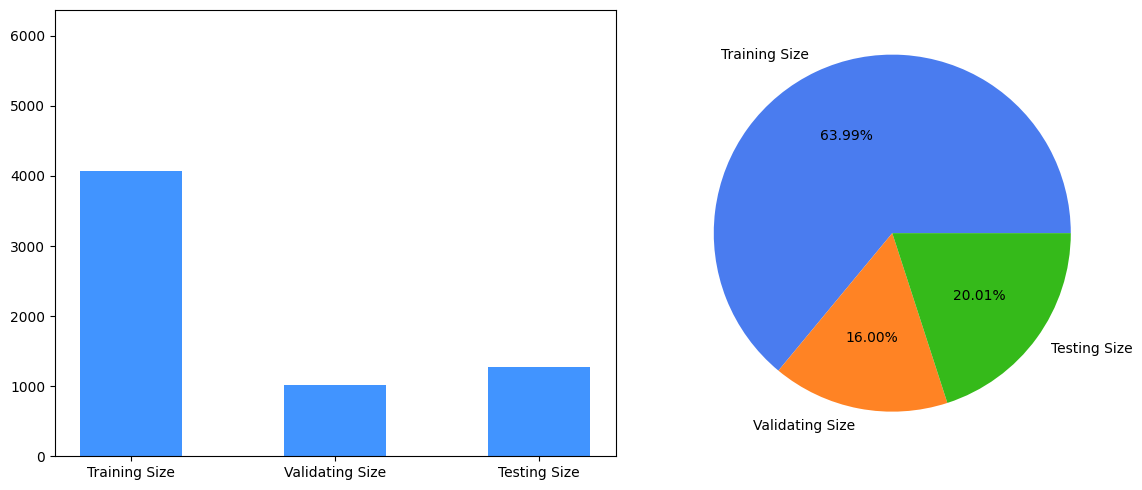

In [12]:
from matplotlib import pyplot as plt

train_size, val_size, test_size = len(train_data), len(val_data), len(test_data)
plot_percentages = [train_size, val_size, test_size] 
plot_labels = ['Training Size', 'Validating Size', 'Testing Size']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(plot_labels, plot_percentages, width=0.5, color=custom_hex_color('#4194FF'))
axes[0].set_ylim(0, len(data))

axes[1].pie(plot_percentages, labels=plot_labels, autopct='%1.2f%%', wedgeprops={'linewidth': 0.3},
            colors=[custom_hex_color('#4A7CEF'), custom_hex_color('#FF8324'), custom_hex_color('#35BA1A')])

# fig.suptitle('\nData Spliting Rating\n', fontsize=20)
plt.tight_layout()
plt.show()

Όπως είπαμε θα χρησιμοποιήσουμε τη βιβλιοθήκη __PyTorch__ της Python. Γι' αυτό το λόγο στη συνέχεια θα δημιουργήσουμε μία δικιά μας κλάση `MusicDataset` η οποία θα κληρονομεί την κλάση `Dataset` της __PyTorch__ και θα υλοποιεί τις απαραίτητες μεθόδους.

In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset

class MusicDataset(Dataset):
    """ Class that represents a music dataset extending the PyTorch Dataset """

    # Static Labels Transformation dictionaries
    LABEL_TRANSFORMATION_DICT = {0: 'classical', 1: 'hiphop', 2: 'rock', 3: 'blues'}
    LABEL_TRANSFORMATION_DICT_INVERT = {'classical': 0, 'hiphop': 1, 'rock': 2, 'blues': 3}

    def __init__(self, data: np.array, labels: np.array) -> None:
        """ Constructor of the Music Dataset. Initializes the data and the labels. """

        self.data = data
        self.labels = labels

        self.__transform_labels() # Make sure our labels are transformed into numbers

    def __transform_labels(self) -> None:
        """ Tranforms the labels of the dataset by changing the text into integer. """

        self.labels = np.array([MusicDataset.LABEL_TRANSFORMATION_DICT_INVERT[category] for category in self.labels])

    def __len__(self) -> int:
        """ Returns the length of the Dataset. """

        return len(self.data)

    def __getitem__(self, index: int) -> tuple[torch.tensor, torch.tensor]:
        """ Returns the data and label located at the given index inside the Dataset. """

        data_item = self.data[index]
        label_item = self.labels[index]

        return torch.tensor(data_item, dtype=torch.float32), torch.tensor(label_item, dtype=torch.long)

Στην παραπάνω υλοποίηση της κλάσης `MusicDataset` φροντίζουμε και __μετατρέπουμε__ τα αποθηκευμένα __labels__ σε __ακέραιους αριθμούς__ έτσι ώστε το νευρωνικό μας δίκτυο να μπορέσει να δουλέψει μόνο με νούμερα. Αυτό το επιτυγχάνουμεμε τη μέθοδο `__transform_labels()` η οποία καλείται με το δημιουργήσουμε κάποιο αντικείμενο της κλάσης. Συγκεκριμένα η αντιστοίχιση των labels σε ακέραιους αριθμούς γίνεται ως εξής:

* 0 $\rightarrow$ classical
* 1 $\rightarrow$ hiphop
* 2 $\rightarrow$ rock_metal_hardrock
* 3 $\rightarrow$ blues

Έχοντας ορίσει την κλάση `MusicDataset`, ας δημιουργήσουμε **3 αντικείμενα** αυτής της κλάσης τα οποία θα αναπαριστούν τα training, validating, και testing data που έχουμε στην κατοχή μας.

In [10]:
# Define our datasets
train_dataset = MusicDataset(train_data, train_labels)
val_dataset = MusicDataset(val_data, val_labels)
test_dataset = MusicDataset(test_data, test_labels)

Τέλος έχοντας ορίσει τα datasets μας, ας δημιουργήσουμε τα 3 [__Pytorch DataLoaders__][dataloder_link] (ένα για κάθε σύνολο δεδομένων) με `batch_size=16`, ώστε να μπορούν να χρησιμοποιηθούν στο μοντέλο μας. Θα δώσουμε επίσης το όρισμα `shuffle=True` για τα **train data** και **validation data**.

[dataloder_link]: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [11]:
from torch.utils.data import DataLoader

# Construct our Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

<hr>

## Ορισμός Μοντέλου - Νευρωνικό Δίκτυο (Neural network) 🤖🧠

Σε αυτό το project θα ασχοληθούμε συγκεκριμένα με [__συνελικτικά νευρωνικά δίκτυα__][cnn_link](Convolutional Neural Networks).

[cnn_link]: https://en.wikipedia.org/wiki/Convolutional_neural_network